# Few-Shot Learning with Presto

### Demo Overview 

The purpose of the Demo is to: 

- show-case how to effectively train models on limited amount of annotated data
- show how multi-sensor and multi-temporal information can be integrated by mean of DL models
- highlight the impact on the performance when using classical ML or Fine-Tuned DL models alone or in combination

To this end, we will:

1) give a short introduction on Foundation Models and Presto
2) provide the definition of Few-Shot learning
3) apply Presto to perfrom Few-Shot learning on a regression and a classification task


### 1) Foundation Models

A Foundation Model is a model trained on large and diverse unlabeled datasets to learn general patterns and features of the data. Thanks to its strong generalization capabilities, such a model can be adapted for a wide range of applications that use similar types of input data.

**Presto** (**P**retrained **Re**mote **S**ensing **T**ransf**o**rmer) is a foundation model trained on a large, unlabeled dataset of Sentinel-2, Sentinel-1, Meteorological and Topography pixel-timeseries data. It is able to capture long-range relationships across time and sensor dimensions, improving the signal-to-noise ratio and providing a concise, informative representation of the inputs. 
In this project, We made use of the Presto version developed in collaboration with [WorldCereal](https://github.com/WorldCereal/presto-worldcereal/)

Originally trained on monthly composites, Presto has been refined to be able to ingest decadal data and to be fine-tuned for regression and classification tasks.

### 2) Few-Shot Learning

Few-shot learning aims to develop models that can learn from a small number of labeled instances while enhancing generalization and performance on new, unseen examples.

Given a dataset with only a few annotated examples, we can fine-tune a pretrained foundation model to either directly handle the downstream task or generate compressed representations of the inputs, which can then be used to train a machine learning model for the downstream task.
The figure below provides an overview of the latter scenario

<div style="text-align: center;">
    <img src="../images/ScaleAG_FM_applications.jpg" alt="Overview of a Foundation Model used to produce embeddings which can be fed as training examples to downstream models for different tasks and applications." width="700" />
    <p><em>Overview of a Foundation Model used to produce embeddings which can be fed as training examples to downstream models for different tasks and applications.</em></p>
</div>

### 3) Implementing Few-Shot learning with Presto

In [1]:
%load_ext autoreload
%autoreload 2
import catboost as cb
from catboost import Pool
import os
from loguru import logger
import geopandas as gpd
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
from scaleagdata_vito.presto.datasets import ScaleAG10DDataset
from scaleagdata_vito.presto.presto_utils import (
    load_pretrained_model_from_url, 
    evaluate,
    evaluate_catboost,
    train_catboost_on_encodings,
)
from scaleagdata_vito.openeo.preprocessing import (
    run_openeo_extraction_job, 
    merge_datacubes
)
from scaleagdata_vito.demo.utils import (
    prepare_data_for_cb,
    prepare_cropland_data_for_presto,
    compare_performance_regression,
    compare_performance_classification,
)
from openeo_gfmap import (
    Backend,
    BackendContext,
    TemporalContext,
    FetchType,
)
from openeo_gfmap.backend import cdse_connection
from openeo_gfmap.manager.job_splitters import split_job_hex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Fetch data from OpenEO

To set up the job, we adapt the job parameters to our needs. the compositing strategy is decadal by default

```python
job_params = dict(
    connection=cdse_connection(),
    backend_context=BackendContext(Backend.CDSE),
    temporal_extent=TemporalContext(
        start_date="yyyy-mm-dd", 
        end_date="yyyy-mm-dd",
    ),
    fetch_type=FetchType.POINT,
    disable_meteo=False,
    out_format="NetCDF", 
    title="...", # name of the job. can be monitored in the OpenEO Editor (https://editor.openeo.org/)
    split_dataset=False, # set to True for big and sparse datasets
    output_path="..." # where to save the extraction result. path to the parent folder when split_dataset=True 
)
```

In [30]:
# load dataframe with labels and polygons we want to extract openeo data for
gdf = (
    gpd.read_file(
        "/projects/TAP/HEScaleAgData/timeseries_modelling/datasets/" \
        "apr2024_AVR_subfields/data/AVR_fields_10000_100000_subfields_yield_bel_nl_roads_removed.geojson"
    ).drop(columns=["date"])
)

# setup OpenEO job parameters
job_params = dict(
    connection=cdse_connection(),
    backend_context=BackendContext(Backend.CDSE),
    temporal_extent=TemporalContext(
        start_date="2022-01-01",
        end_date="2022-12-31",
    ),
    fetch_type=FetchType.POINT,
    disable_meteo=False,
    out_format="NetCDF",
    title="ScaleAGData_demo",
    split_dataset=False,
    output_path="/home/vito/millig/gio/data/scaleag_demo/test1"
)

output_path = Path(job_params["output_path"])
if not os.path.exists(job_params["output_path"]):
    output_path.mkdir(parents=True, exist_ok=True)

Authenticated using refresh token.


In [14]:
if job_params["split_dataset"]:
    datasets = split_job_hex(gdf)
    for i, sub_gdf in enumerate(datasets):
        logger.info(f"Extracting OpenEO data for subset {i}")
        output_path_frame = output_path / f"cube_{i}"
        output_path_frame.mkdir(parents=True, exist_ok=True)
        run_openeo_extraction_job(sub_gdf, str(output_path_frame), job_params)
    subset_files = list(output_path.glob("*/*.nc"))
    dataset = subset_files[0]
    for d in subset_files[1:]:
        dataset = merge_datacubes(dataset, d)
    dataset.to_netcdf(output_path / "demo_dataset_yield.nc")
else:
    logger.info(f"Extracting OpenEO data for dataset")
    run_openeo_extraction_job(gdf, str(output_path), job_params)

2024-09-13 10:56:23.637 | INFO     | __main__:<module>:14 - Extracting OpenEO data for dataset


Selected orbit direction: ASCENDING from max accumulated area overlap between bounds and products.


KeyboardInterrupt: 

#### Regression task: yield estimation 

Potato yield estimation. The data cover fields in Belgium and The Netherlands during the growing season. 
In order to test the generalization capabilities of the different models and combinations, we limit data correlation by using data from Belgium as training set and those from The Netherlands as validation set.

In [5]:
# load preprocessed datasets
train_df = pd.read_parquet(
    "/home/vito/millig/projects/TAP/HEScaleAgData/data/AVR_subfields/"
    "train_avr_subfields_10d_BE_4-10_filtered.parquet"
    # "train_avr_subfields_10d_BE_NL_4-10_filtered.parquet"
)
val_df = pd.read_parquet(
    "/home/vito/millig/projects/TAP/HEScaleAgData/data/AVR_subfields/"
    "val_avr_subfields_10d_NL_4-10_filtered.parquet"
    # "val_avr_subfields_10d_BE_NL_4-10_filtered.parquet"
)
print(f"Number of Training samples: {len(train_df)}")
print(f"Number of Validation samples: {len(val_df)}")

Number of Training samples: 6229
Number of Validation samples: 4186


In [6]:
# val_df.head(5)

In [7]:
dl_train = DataLoader(
    ScaleAG10DDataset(
        train_df, target_name="median_yield", task="regression"
    ),
    batch_size=256,
    shuffle=True,
    num_workers=2,
)

dl_val = DataLoader(
    ScaleAG10DDataset(
        val_df, target_name="median_yield", task="regression"
    ),
    batch_size=256,
    shuffle=False,
    num_workers=2,
)

##### Train Catboost on Presto Encodings

In [8]:
presto_ss_10d_wc_ft_yield = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ss-wc_10D_NL-BE_4-10_ft.pt"
model_ft_10d_yield = load_pretrained_model_from_url(
    presto_ss_10d_wc_ft_yield, finetuned=True, ss_dekadal=True, strict=False, device="cpu"
)
presto_cbm = train_catboost_on_encodings(
    dl_train, 
    presto_model=model_ft_10d_yield, 
    task="regression", 
    cb_device="GPU"
    )

2024-09-16 10:23:35.884 | INFO     | scaleagdata_vito.presto.presto_utils:load_pretrained_model_from_url:94 -  Initialize Presto dekadal architecture with dekadal PrestoFT...
2024-09-16 10:23:36.132 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:356 - Computing Presto encodings
2024-09-16 10:24:28.672 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:358 - Fitting Catboost model on Presto encodings
TBB Warning: The number of workers is currently limited to 1. The request for 95 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



##### Train Catboost on raw data

In [9]:
train_cx, train_cy = prepare_data_for_cb(
    train_df, 
    target_name="median_yield",     
    lower_bound=dl_train.dataset.LOWER_BOUND, 
    upper_bound=dl_train.dataset.UPPER_BOUND, 
    )

val_cx, val_cy = prepare_data_for_cb(
    val_df, 
    target_name="median_yield",     
    lower_bound=dl_val.dataset.LOWER_BOUND, 
    upper_bound=dl_val.dataset.UPPER_BOUND, 
    )

In [10]:
raw_cbm = cb.CatBoostRegressor(
    random_state=3, 
    logging_level="Silent",
    task_type="GPU",
    loss_function="RMSE",
    )
train_pool = Pool(train_cx, train_cy)
raw_cbm.fit(train_pool);

##### Evaluate and Compare Performance

- **R² Score**: Measures how well the regression model predictions match the actual data

- **Mean Absolute Percentage Error (MAPE)**: Measures the average percentage difference between predicted and actual values, providing an idea of the model prediction accuracy

- **Explained Variance Score**: Measure of how well the model explains the variability in the data


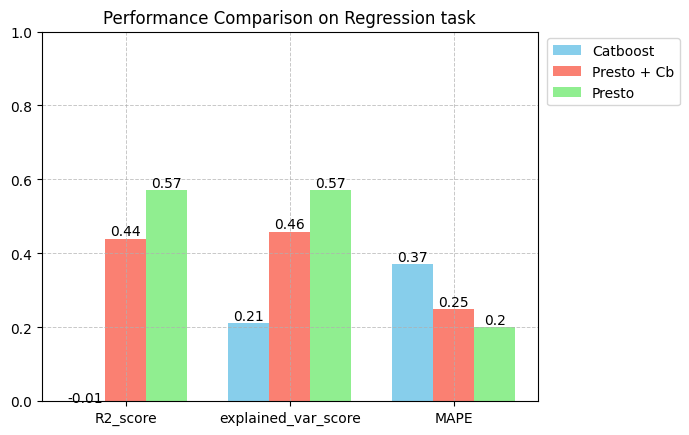

In [11]:
metrics_presto, _, _ = evaluate(
    pretrained_model=model_ft_10d_yield,
    dl_val=dl_val,
    task="regression",
    up_val=dl_val.dataset.UPPER_BOUND,
    low_val=dl_val.dataset.LOWER_BOUND,
)
metrics_presto_cb, _, _ = evaluate(
    pretrained_model=model_ft_10d_yield,
    ds_model=presto_cbm,
    dl_val=dl_val,
    task="regression",
    up_val=dl_val.dataset.UPPER_BOUND,
    low_val=dl_val.dataset.LOWER_BOUND,
)
metrics_raw_cb, _, _ = evaluate_catboost(
    raw_cbm,
    val_cx,
    val_cy,
    task="regression",
    up_val=dl_val.dataset.UPPER_BOUND,
    low_val=dl_val.dataset.LOWER_BOUND,
)
compare_performance_regression(metrics_raw_cb, metrics_presto_cb, metrics_presto)

#### Classification task: Crop/No-Crop

Data sampled globally and randomly split in training and validation

In [12]:
wc_train_dataset = pd.read_parquet(
    "/home/vito/millig/gio/data/presto_ft/rawts-10d_train.parquet"
)

wc_val_dataset = pd.read_parquet(
    "/home/vito/millig/gio/data/presto_ft/rawts-10d_val.parquet"
)

wc_train_dataset = prepare_cropland_data_for_presto(wc_train_dataset, sample_frac=0.015)
wc_val_dataset = prepare_cropland_data_for_presto(wc_val_dataset, sample_frac=0.04)

print(f"Number of Training samples: {len(wc_train_dataset)}")
print(f"Number of Validation samples: {len(wc_val_dataset)}")

Number of Training samples: 6835
Number of Validation samples: 4555


In [13]:
wc_dl_train = DataLoader(
    ScaleAG10DDataset(
        wc_train_dataset, 
        target_name="LANDCOVER_LABEL",
        task="binary",
    ),
    batch_size=256,
    shuffle=True,
    num_workers=2,
)
wc_dl_val = DataLoader(
    ScaleAG10DDataset(
        wc_val_dataset,
        target_name="LANDCOVER_LABEL",
        task="binary",
    ),
    batch_size=256,
    shuffle=False,
    num_workers=2,
)

##### Train Catboost on Presto Encodings

In [14]:
presto_10d_ft_cropland = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ft-cl_10D_cropland.pt"
model_ft_10d_cropland = load_pretrained_model_from_url(
    presto_10d_ft_cropland, finetuned=True, strict=False, device="cpu"
    )

wc_presto_cbm = train_catboost_on_encodings(
    wc_dl_train,
    presto_model=model_ft_10d_cropland,
    task="binary",
    cb_device="GPU",
)

2024-09-16 10:26:16.899 | INFO     | scaleagdata_vito.presto.presto_utils:load_pretrained_model_from_url:94 -  Initialize Presto dekadal architecture with dekadal PrestoFT...
2024-09-16 10:26:17.133 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:356 - Computing Presto encodings
2024-09-16 10:28:03.694 | INFO     | scaleagdata_vito.presto.presto_utils:train_catboost_on_encodings:358 - Fitting Catboost model on Presto encodings


##### Train Catboost on raw data

In [15]:
wc_train_cx, wc_train_cy = prepare_data_for_cb(
    wc_train_dataset, 
    target_name="LANDCOVER_LABEL",     
    )

wc_val_cx, wc_val_cy = prepare_data_for_cb(
    wc_val_dataset, 
    target_name="LANDCOVER_LABEL",     
    )

In [16]:
wc_raw_cbm = cb.CatBoostClassifier(
    random_state=3,
    task_type="GPU",
    logging_level="Silent",
)
wc_train_dataset = cb.Pool(wc_train_cx, wc_train_cy)
wc_raw_cbm.fit(wc_train_dataset);

##### Evaluate and Compare Performance
- **Recall**: Measures the proportion of true positives successfully identified by the model

- **Precision**: Measures the proportion of predicted positive cases being actually positive

- **F1-Score**: Combines precision and recall into a single metric by calculating their harmonic mean. It balances the trade-off between precision and recall, especially useful when you need a single measure of performance.

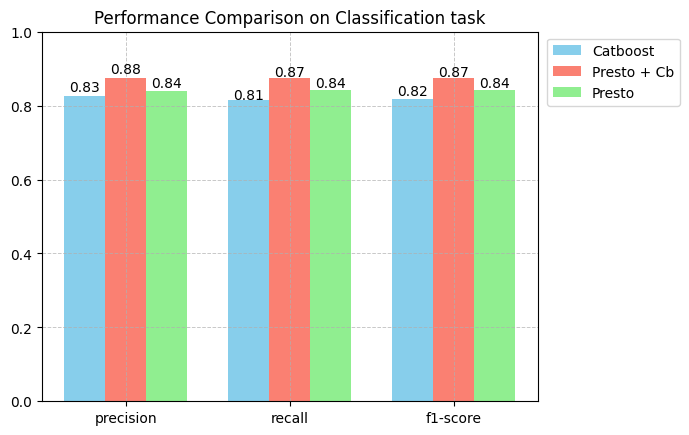

In [17]:
wc_metrics_presto, _, _ = evaluate(
    pretrained_model=model_ft_10d_cropland,
    dl_val=wc_dl_val,
    task="binary",
)
wc_metrics_presto_cb, _, _ = evaluate(
    pretrained_model=model_ft_10d_cropland,
    ds_model=wc_presto_cbm,
    dl_val=wc_dl_val,
    task="binary",
)
wc_metrics_raw_cb, _, _= evaluate_catboost(
    wc_raw_cbm, 
    wc_val_cx,
    wc_val_cy,
    task="binary"
)
compare_performance_classification(wc_metrics_raw_cb, wc_metrics_presto_cb, wc_metrics_presto)

### Conclusions

- Fine-tuning a foundation model on a target dataset for a specific task can match or exceed the performance of a traditional ML model trained in a supervised manner on raw data.
- Foundation Models can be used to integrate multi-sensor and multi-temporal data and create compressed versions of inputs while retaining the important information or to perform the target task directly. The latter solution usually grants better generalization capabilities
- classical ML models are more sensitive to overfitting and have limited generalization capabilities on unseen data

#### Next steps
- Test in the R&I environment 
- Implement Presto Fine-Tuning in notebook to allow for customizable training 
- Improve Few-Shot learning: good overall performance at reduced dataset size 
- Test Presto on different downstream tasks and applications